## West Nile Virus (WNV) Public Health Analysis Project 2

##### Preliminaries: <span style="font-size:14px; font-weight:normal;">Importing libraries and data, peaking at the data, and eliminating capital letters and white space from our dataframe. </span>

In [244]:
# Importing libraries:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import seaborn as sns
import statsmodels.api as sm

In [245]:
# Importing the data: 

df = pd.read_csv('C:/Users/simon/Downloads/mosquito_data_part_2_2024.csv')

In [246]:
# Checking at the first 5 entries of our dataframe:

df.head()

,Year,Week,Address Block,Trap,Trap type,Date,Mosquito number,WNV Present,Species,Lat,Lon,Month
0,2019,39,100XX W OHARE AIRPORT,T910,GRAVID,2019-09-26 00:09:00,2,negative,CULEX RESTUANS,41.977738,-87.880969,9
1,2019,39,52XX S KOLMAR AVE,T114,GRAVID,2019-09-26 00:09:00,1,negative,CULEX RESTUANS,41.798211,-87.736925,9
2,2019,39,58XX N WESTERN AVE,T028,GRAVID,2019-09-26 00:09:00,2,negative,CULEX RESTUANS,41.987245,-87.689417,9
3,2019,39,39XX N SPRINGFIELD AVE,T228,GRAVID,2019-09-26 00:09:00,1,negative,CULEX RESTUANS,41.953664,-87.724987,9
4,2019,39,131XX S BRANDON AVE,T209,GRAVID,2019-09-26 00:09:00,9,negative,CULEX RESTUANS,41.657069,-87.546049,9


In [247]:
# Checking which data types are stored: 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18495 entries, 0 to 18494
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year             18495 non-null  int64  
 1   Week             18495 non-null  int64  
 2   Address Block    18495 non-null  object 
 3   Trap             18495 non-null  object 
 4   Trap type        18495 non-null  object 
 5   Date             18495 non-null  object 
 6   Mosquito number  18495 non-null  int64  
 7   WNV Present      18495 non-null  object 
 8   Species          18495 non-null  object 
 9   Lat              18495 non-null  float64
 10  Lon              18495 non-null  float64
 11  Month            18495 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 1.7+ MB


*Note*: columns *address_block*, *trap*, *trap_type*, *date*, *wnv_present*, and *species* are all object type data.

In [248]:
# Checking out how many null values each column has:

df.isna().sum()

Year               0
Week               0
Address Block      0
Trap               0
Trap type          0
Date               0
Mosquito number    0
WNV Present        0
Species            0
Lat                0
Lon                0
Month              0
dtype: int64

As expected, since we are using a cleaned dataframe, none of the columns have null values stored. 

In [249]:
# Eliminating capital letters and white space in column names:

df.columns=df.columns.str.strip().str.lower().str.replace(' ', '_', regex=False).str.replace('(', '', regex=False).str.replace(')', '', regex=False)

We eliminated capital letters and white space from our column names to facilitate with cleaner codes. However, as we create more dummy variables, we will have to continue to eliminate any new capital letters or white space that will arise from such creations.

### Part 1 - Basic Analysis

#### Question 1.1: <span style="font-size:14px; font-weight:normal;"> ***Converting the wnv_present column into a binary column and creating dummy variables from the trap_type column*** </span> 

We are asked to convert the *wnv_present* column into a binary column and create dummy variables from the *trap_type* column. As noted above, both the *wnv_present* and *trap_type* columns store string values. Let us first see the unique values in each of the two columns.

In [250]:
# Getting the unique values in 'wnv_present':

unique_values_wnv_present = df['wnv_present'].unique()
print(unique_values_wnv_present)

['negative' 'positive']


In [251]:
# Getting the unique values in 'trap type':

unique_values_trap_type = df['trap_type'].unique()
print(unique_values_trap_type)

['GRAVID' 'SENTINEL' 'CDC' 'OVI']


To convert the *wnv_present* column to a binary one, we will map the *positive* values to 1 and the *negative* values to 0. Our choice for this mapping is a natural one since we are interested in exploring the presence of WNV at any particular time and location. 

In [252]:
# Converting the 'WNV Present' to binary column:

df['wnv_present'] = np.where(df['wnv_present'] == 'positive', 1, 0)

Now we will create dummy variables from the *trap_type* column, followed by eliminating any capital letters or white space formed by our new dummy variables.  

In [253]:
# Creating dummy variables for 'trap_type':
dummy_one = pd.get_dummies(df['trap_type'], prefix = 'trap', dtype=int) #Adding a prefix for clarity

# Concatenating dummy variables with original DataFrame: 
df = pd.concat([df, dummy_one], axis=1)

# Dropping the original 'Trap type' column:
df.drop('trap_type', axis=1, inplace=True)

In [254]:
# Eliminating capital letters and white space in column names:

df.columns=df.columns.str.strip().str.lower().str.replace(' ', '_', regex=False).str.replace('(', '', regex=False).str.replace(')', '', regex=False)

In [255]:
# Checking that we did our conversion and elimination properly:

column_names = df.columns
print(column_names)

Index(['year', 'week', 'address_block', 'trap', 'date', 'mosquito_number',
       'wnv_present', 'species', 'lat', 'lon', 'month', 'trap_cdc',
       'trap_gravid', 'trap_ovi', 'trap_sentinel'],
      dtype='object')


In [256]:
# Checking that *wnv_present* only has binary values: 

unique_values_wnv_present = df['wnv_present'].unique()
print(unique_values_wnv_present)

[0 1]


#### Question 1.2: <span style="font-size:14px; font-weight:normal;"> ***Finding the average number of mosquitoes for each month and observing any trends*** </span>

There are two ways we can approach this question. The first method is to find the expected number of mosquitoes caught, per trap, for a given month, over all years. The second method would be to find the expected total number of mosquitoes caught, across all traps, per month, over all years. Let us start with the first method. 

In [257]:
# Calculating the average number of mosquitos caught, per trap, for a given month, over all years: 

average_mosquitoes_per_month_1 = df.groupby('month')['mosquito_number'].mean()
print(average_mosquitoes_per_month_1)

month
5      2.761905
6     10.264442
7     11.551879
8     12.111321
9      8.394973
10     5.377778
Name: mosquito_number, dtype: float64


For example, in month 8 (August), we can expect that a randomly selected trap has caught 12 mosquitoes.

We can use a line graph to visualize any noticeable trend. 

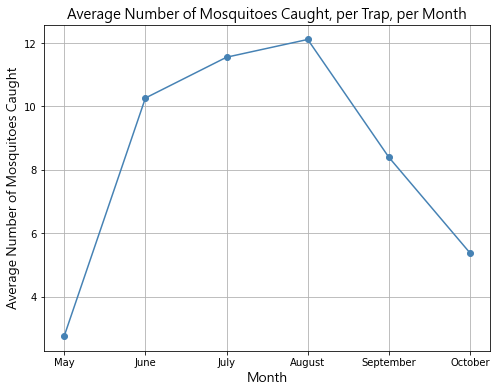

In [258]:
# Plotting a line graph:
plt.figure(figsize=(8, 6))
plt.plot(average_mosquitoes_per_month_1.index, average_mosquitoes_per_month_1.values, color= 'steelblue', marker='o', linestyle='-')

# Adding labels and titles:
plt.title('Average Number of Mosquitoes Caught, per Trap, per Month', fontdict={'fontname': 'Microsoft JhengHei', 'fontsize' : 14})
plt.xlabel('Month', fontdict={'fontname': 'Microsoft JhengHei', 'fontsize' : 13})
plt.ylabel('Average Number of Mosquitoes Caught', fontdict={'fontname': 'Microsoft JhengHei', 'fontsize' : 13})

# Creating custom labels to convert numerical representations of months to their names, for clarity
custom_labels = ['May', 'June', 'July', 'August', 'September', 'October']
plt.xticks(range(5, 11), custom_labels)  # Restricting the range to only include the months in our dataset
plt.grid(True)
plt.show()

***Observations***:
    
It appears there is a trend when it comes to the average number of mosquitoes caught, per trap, and the months.
Average mosquito numbers were on a steep increase between the months of May to June, with a significantly slower, but steady increase, between July and August, with the peak occuring in August followed by another steap decline in the September and October months.

The graph indicates that July and August, which are both hot and humid summer months, are the top months for the highest number of mosquitoes caught, per trap.

Now we will calculate the average number of mosquitoes caught, across all traps, for any given month, over all years. 

In [259]:
# Calculating the average number of mosquitoes caught, across all traps, per month, and over all years:

average_mosquitoes_per_month_2 = df.groupby(['year','month']).sum()['mosquito_number']
average_2 = average_mosquitoes_per_month_2.groupby(['month']).mean().round(2)
print(average_2)

month
5       58.00
6     2200.54
7     4539.00
8     6402.23
9     2235.00
10     302.50
Name: mosquito_number, dtype: float64


For example, in month 8 (August), we can expect an average of 6,402 mosquitoes caught, across all traps.

Again, we will create a line graph to visualize any trends.

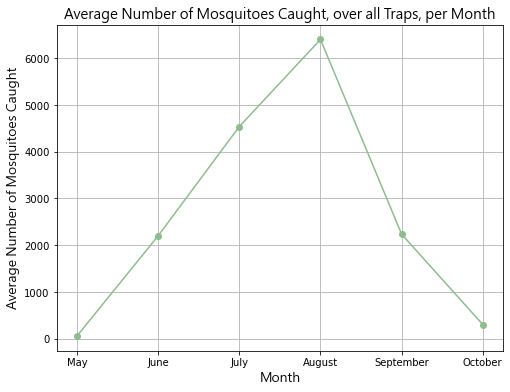

In [260]:
# Plotting a line graph:
plt.figure(figsize=(8, 6))
plt.plot(average_2.index, average_2.values, color='darkseagreen', marker='o', linestyle='-')

# Adding labels and titles:
plt.title('Average Number of Mosquitoes Caught, over all Traps, per Month', fontdict={'fontname': 'Microsoft JhengHei', 'fontsize' : 14})
plt.xlabel('Month', fontdict={'fontname': 'Microsoft JhengHei', 'fontsize' : 13})
plt.ylabel('Average Number of Mosquitoes Caught', fontdict={'fontname': 'Microsoft JhengHei', 'fontsize' : 13})

# Creating custom labels to convert numerical representations of months to their names, for clarity
custom_labels = ['May', 'June', 'July', 'August', 'September', 'October']
plt.xticks(range(5, 11), custom_labels)  # Restricting the range to only include the months in our dataset
plt.grid(True)
plt.show()

***Observations***:

It appears there is a trend when it comes to the average of total mosquitos caught and the months. Mosquito averages were on a steady increase between the months of May to July peak numbers occuring in August followed by a steap decline in the September and October months.

For both average, the overall trends are the same: mosquito numbers climbs from May to August, peak at August, and then descend from August to October. That is, August is the month with highest expected number of mosquitoes caught, both per trap and across all traps.

### Part 2 - Statistical Analysis

#### Question 2.1: <span style="font-size:14px; font-weight:normal;"> ***Determining if there is a statistically significant difference between the different mosquito species and the occurrence of WNV*** </span> 

Since the variables in question are all categorical, we will use a $\chi^{2}$ test to run against the null hypothesis that there is no statistical difference between the mosquito species and the occurrence of WNV.

In [261]:
# Grouping by 'Species' and 'WNV Present' and count occurrences:
contingency_table = df.groupby(['species', 'wnv_present'])['wnv_present'].count().unstack()

# Renaming columns for clarity:
contingency_table.columns = ['WNV Negative', 'WNV Present']

# Converting the contingency table to integer type:
contingency_table = contingency_table.astype(int)

# Displaying the contingency table:
print(contingency_table)

                  WNV Negative  WNV Present
species                                    
CULEX PIPIENS             4074         1412
CULEX RESTUANS            9309         2557
CULEX SALINARIUS           215           11
CULEX TERRITANS            903           14


In [262]:
# Calculating the chi-squared test:

chi_square = stats.chi2_contingency(contingency_table)
print(chi_square)

(311.10394683130164, 3.9302341764409087e-67, 3, array([[4301.29689105, 1184.70310895],
       [9303.5342525 , 2562.4657475 ],
       [ 177.19524196,   48.80475804],
       [ 718.97361449,  198.02638551]]))


In [263]:
# Getting the p-value from the chi-squared test:
chi_square, p_value, dof, expected = stats.chi2_contingency(contingency_table)

# Printing the p-value
print("p-value:", p_value)

p-value: 3.9302341764409087e-67


***Conclusion***:

Since the $p$-value ($\approx$ 0) is much smaller than the significance level of $\alpha$ = 0.05, 
we can reject the null hypothesis and conclude that there is a statistically significant difference 
between the mosquito species and the occurrence of WNV.

#### Question 2.2: <span style="font-size:14px; font-weight:normal;"> ***Determining which columns are positively correlated and negatively correlated with the number of mosquitoes caught and which correlations are statistically significant*** </span>

For this question we need to determine which columns are positively correlated and negatively correlated with the number of mosquitoes caught and if these correlations are statistically significant. To do this, we will run a Pearson test which will show the correlation coefficients between all the columns against the number of mosquitos caught, along with their $p$-values.

However, before we run the Pearson test, we need to make sure that each of our columns has either an integer or float data type.  Since the remaining questions will deal with columns that have numerical values, we can finish preparing our data set 
by either converting appropriate columns to binary ones, creating dummy variables or dropping columns that 
should neither be converted to binary ones nor create dummy variables from.

The decision not to create dummy variables from a given column with string values (object data type) rests on the number of variables created from such a process. If there are too many unique string values in a given column then the number of variables created would be too high and would hinder our analysis. In such cases, we drop the column. 

In order to identify which columns we should drop, we can determine how many unique values each string valued column holds.  

*Note*: We have shown in the previous question that the remaining columns with string values are *address_block*, *trap*, *date*, and *species*.   

In [264]:
# Checking the number of unique values in the 'Address Block' column:

df['address_block'].nunique()

154

In [265]:
# Checking the number of unique values in the 'Trap' column:

df['trap'].nunique()

190

In [266]:
# Checking the number of unique values in the 'Date' column:

df['date'].nunique()

298

In [267]:
# Checking the number of unique values in the 'Species' column:

df['species'].nunique()

4

Clearly, the columns *address_block*, *trap* and *date* are not candidates for conversion to binary data or dummy variables due 
to their high count in unique values. However, the *species* column is a good candidate to create dummy variables from since the column only has 4 unique values. The cost of adding 4 extra columns to our dataframe (and dropping *species*) is far smaller than the benefit of retaining the information in the *species* column. 

Therefore, we will drop the *address_block*, *trap* and *date* columns and create dummy variables from the *species* column. Once the dummy variables are created, we will drop the *species* column as well and eliminate all capital letters and white space. Finally, we will rearrange the columns in our dataframe so that the columns have an organized sequence (for example, keeping year, month, and week side by side). 

In [268]:
# Dropping the columns:

df.drop('address_block', axis = 1, inplace=True)
df.drop('trap', axis = 1, inplace=True)
df.drop('date', axis = 1, inplace=True)

In [269]:
# Creating dummy variables for 'species':
dummy_two = pd.get_dummies(df['species'], dtype=int)

# Concatenating dummy variables with original data frame: 
df = pd.concat([df, dummy_two], axis=1)

In [270]:
# Dropping the original 'species' column:

df.drop('species', axis=1, inplace=True)

In [271]:
# Eliminating capital letters and white space in column names:

df.columns=df.columns.str.strip().str.lower().str.replace(' ', '_', regex=False).str.replace('(', '', regex=False).str.replace(')', '', regex=False)

In [272]:
# Rearranging columns: 

df=df[['year', 'month', 'week', 'mosquito_number', 'wnv_present', 'trap_cdc', 'trap_gravid', 'trap_ovi', 'trap_sentinel', 'culex_pipiens', 'culex_restuans', 'culex_salinarius', 'culex_territans', 'lat', 'lon']]

In [273]:
# Checking for any remaining string values:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18495 entries, 0 to 18494
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              18495 non-null  int64  
 1   month             18495 non-null  int64  
 2   week              18495 non-null  int64  
 3   mosquito_number   18495 non-null  int64  
 4   wnv_present       18495 non-null  int32  
 5   trap_cdc          18495 non-null  int32  
 6   trap_gravid       18495 non-null  int32  
 7   trap_ovi          18495 non-null  int32  
 8   trap_sentinel     18495 non-null  int32  
 9   culex_pipiens     18495 non-null  int32  
 10  culex_restuans    18495 non-null  int32  
 11  culex_salinarius  18495 non-null  int32  
 12  culex_territans   18495 non-null  int32  
 13  lat               18495 non-null  float64
 14  lon               18495 non-null  float64
dtypes: float64(2), int32(9), int64(4)
memory usage: 1.5 MB


Since all of our columns now have only numerical values, we can safely run our Pearson test.

In [274]:
# Definining our positively and negatively correlated columns:

positively_correlated = []
negatively_correlated = []

# Calculating the correlation coefficients with 'mosquito_number' column for each column:
y = df['mosquito_number']
for col in df.columns:
    if col != 'mosquito_number':
        correlation, p_value = stats.pearsonr(df[col], y)
        if correlation > 0:
            positively_correlated.append((col, correlation, p_value))
        elif correlation < 0:
            negatively_correlated.append((col, correlation, p_value))

# Printing the results for positively correlated columns, along with their p-values:
print("Positive correlations:")
for col, correlation, p_value in positively_correlated:
    print(f"The correlation between mosquito_number and {col} is {correlation} with p-value {round(p_value, 4)}.")

# Printing the results for negatively correlated columns, along with their p-values:
print("\nNegative correlations:")
for col, correlation, p_value in negatively_correlated:
    print(f"The correlation between mosquito_number and {col} is {correlation} with p-value {round(p_value, 4)}.")

Positive correlations:
The correlation between mosquito_number and year is 0.1293259454937104 with p-value 0.0.
The correlation between mosquito_number and wnv_present is 0.40803439689029863 with p-value 0.0.
The correlation between mosquito_number and trap_cdc is 0.09414701564247441 with p-value 0.0.
The correlation between mosquito_number and trap_sentinel is 0.10857486046661545 with p-value 0.0.
The correlation between mosquito_number and culex_pipiens is 0.014730275197043063 with p-value 0.0452.
The correlation between mosquito_number and culex_restuans is 0.07099925346799665 with p-value 0.0.
The correlation between mosquito_number and lat is 0.09681989674648903 with p-value 0.0.

Negative correlations:
The correlation between mosquito_number and month is -0.04042643719660077 with p-value 0.0.
The correlation between mosquito_number and week is -0.03389960754496083 with p-value 0.0.
The correlation between mosquito_number and trap_gravid is -0.13827479127699155 with p-value 0.0.
T

***Observations***:

The variable with the strongest correlation with *mosquito_number* is *wnv_present* where $r$ = 0.408. 

*mosquito_number* has weak positive correlations with the variables *year*, *trap_cdc*, *trap_sentinel*, *culex_pipiens*, *culex_restuans*, and *lat*.

*mosquito_number* has weak negative correlations with the variables *month*, *week*, *trap_gravid*, *trap_ovi*, *trap_salinarius*, *culex_territans*, and *lon*.

All the variables are statistically significant (since their $p$-value < 0.05) except for *trap_ovi*, whose $p$-value = 0.4634.

### Part 3 - Advanced Statistical Analysis

#### Question 3.1: <span style="font-size:14px; font-weight:normal;"> ***Running and analyzing a linear regression model against the number of mosquitoes caught*** </span> 

This question asks us to run a linear regression model to determine how the independent (predictor) variables affect the number of mosquitoes caught. Since there will be more than one independent variable, we will be running a multiple linear regression model. 

Also, the question indicates that we should not be using *wnv_present* as one of our independent variables, so we will be dropping it from a copy of our dataframe. Indeed, we will be using a copy of our dataframe for this first question since we will be using the original dataframe for the next question.

*Note*: we will not be dropping one of our dummy variables at the moment (even though it is standard to do so). We will drop at least one dummy variable as we iterate through our modelling process though. 

In [275]:
# Making a copy of original dataframe:
df_copy = df.copy()

# Dropping 'wnv_present' from the copy:
df_copy.drop('wnv_present', axis=1, inplace=True)

However, before we run any linear regression models, we need to check two of the four linear regression assumptions:

1. There is a linear relationship between the independent and dependent variables.

2. The independent (predictor) variables are independent and identically distributed. 

##### Linear Regression Assumption 1: There is a linear relationship between the independent and dependent variables

To check this assumption, we are going to create scatter plots and check for a linear relationship between every indepedent variable and the dependent variable. In this case, our dependent variable is *mosquito_number*.

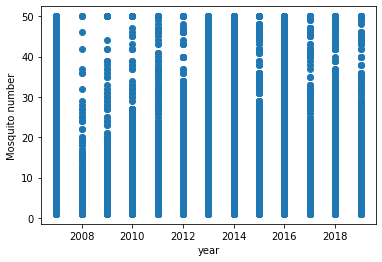

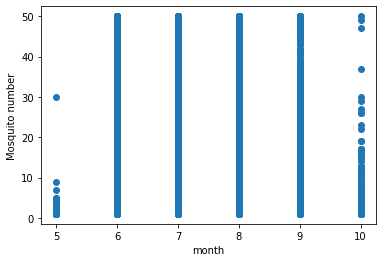

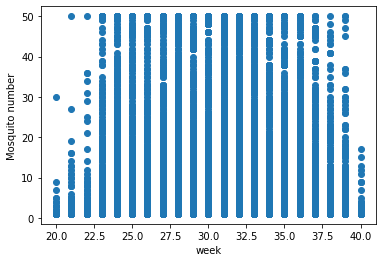

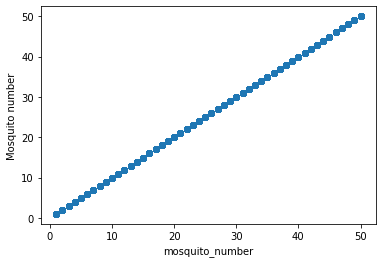

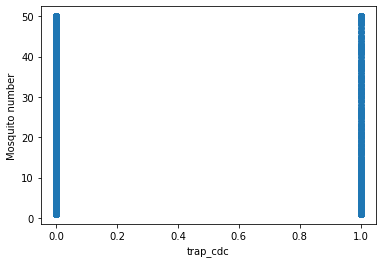

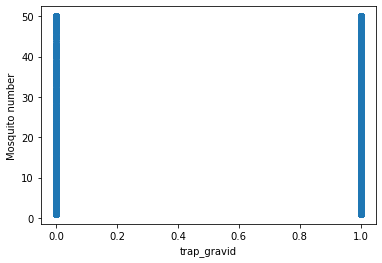

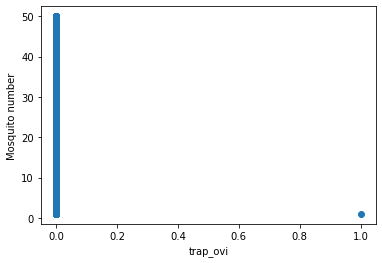

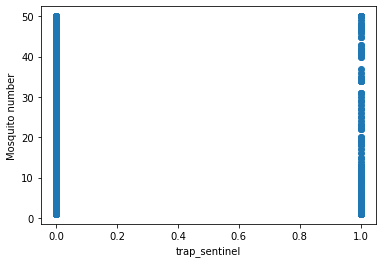

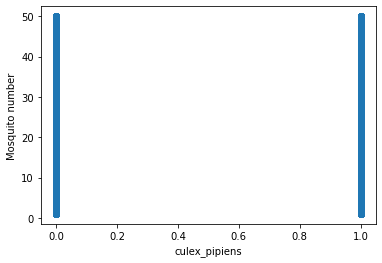

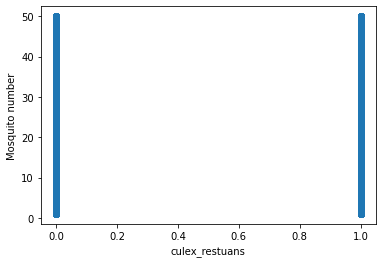

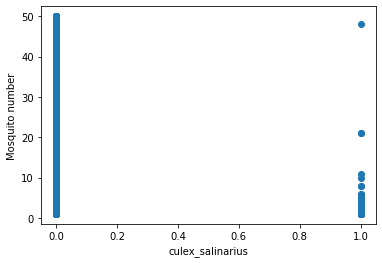

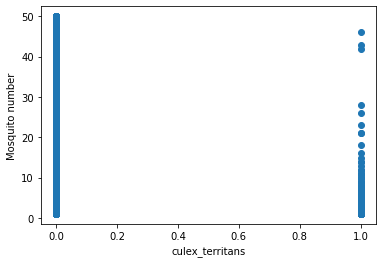

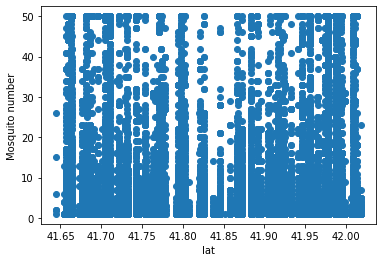

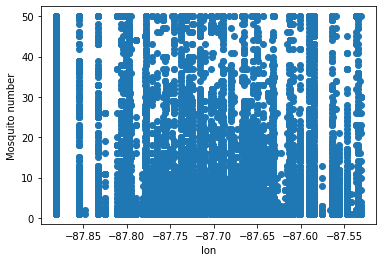

In [276]:
# Creating the dependent variable:
y = df_copy['mosquito_number']

# Creating scatterplots for each independent variable:
for col in df_copy.columns: 
    plt.figure()
    plt.scatter(df_copy[col], y)
    plt.ylabel('Mosquito number')
    plt.xlabel(col)
    plt.show();

***Observations***:

As per our scatterplots, there are no linear relationships with any of the independent variables and the dependent variable.

However, if we recall our observations from *Question 2.2*, we found that *mosquito_number* had a weak correlation with 
all the independent variables (indicating a weak linear relatoinship), where the correlations were significant, save for *trap_ovi*.

##### Linear Assumption 2: The independent (predictor) variables are independent and identically distributed
 
We will not be checking if each independent (predictor) variable is identically distributed; we will simply assume that each variable was randomly selected from their respective population.

For independence, we will only be checking pairwise independence via a correlation matrix, illustarted by a heatmap. 
It should be noted that VIF analysis is not recommended for this question, so we will not perform it.

It should also be noted that dropping variables from the correlation matrix does not change the pairwise correlation coefficients with the remaining variables. Therefore, this heatmap will suffice for our analysis and we will not continue to reiterate the heatmap every time an independent variable is dropped from the model.

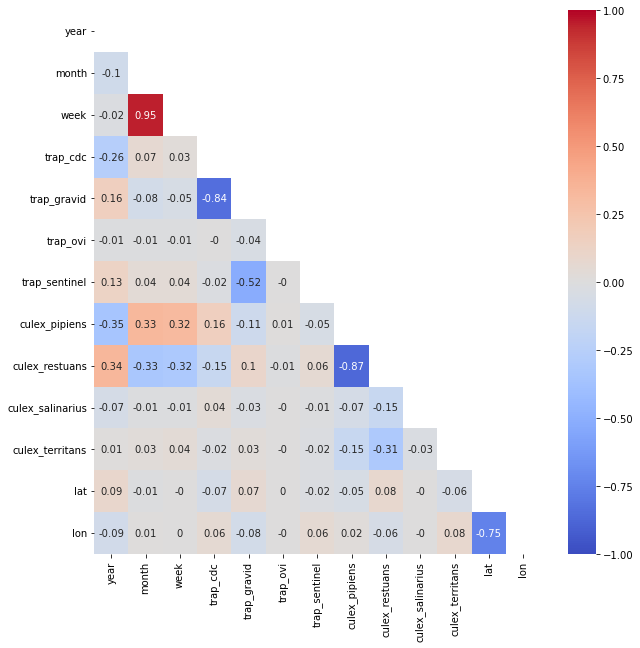

In [277]:
# Defining the matrix X of independent variables: 
X = df_copy[['year', 'month', 'week', 'trap_cdc','trap_gravid', 'trap_ovi', 'trap_sentinel', 'culex_pipiens', 'culex_restuans', 'culex_salinarius', 'culex_territans','lat', 'lon']]

# Defining the dependent variable y:
y = df_copy['mosquito_number']

# Calculating the correlation matrix:
corr = X.corr()

# Creating the heatmap:
plt.figure(figsize=(10, 10))
sns.heatmap(corr.round(2), annot=True, vmax=1, vmin=-1, center=0, cmap="coolwarm", mask=np.triu(corr))
plt.show()

The above heatmeat suggests that quite a few variable pairs are highly correlated, and, as such, one of the two variables from each pair should be dropped from the model. Here is a list of the pairs with an absolute value of the sample correlation coefficient greater than 0.5. 

In [278]:
# Create a list to store the pairs of variables and their absolute coefficients
pairs_with_coefficients = []

# Iterate over the correlation matrix
for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):
        # Check if the correlation coefficient is greater than or equal to 0.3
        if abs(corr.iloc[i, j]) >= 0.5:
            # Append the pair of variables and their absolute coefficient to the list
            pairs_with_coefficients.append((corr.columns[i], corr.columns[j], abs(corr.iloc[i, j])))

# Sort the list based on the absolute coefficients in descending order
sorted_pairs = sorted(pairs_with_coefficients, key=lambda x: x[2], reverse=True)

# Print the pairs of variables and their absolute coefficients
for pair in sorted_pairs:
    print(f"Variable pairs: {pair[0]}, {pair[1]}, |r|= {round(pair[2], 2)}")

Variable pairs: month, week, |r|= 0.95
Variable pairs: culex_pipiens, culex_restuans, |r|= 0.87
Variable pairs: trap_cdc, trap_gravid, |r|= 0.84
Variable pairs: lat, lon, |r|= 0.75
Variable pairs: trap_gravid, trap_sentinel, |r|= 0.52


The choice of which variable to drop from each pair may not always be a simply one. For example, our heatmap suggests that we should drop either *month* or *week* from our model, since they are almost perfectly correlated. However, the *week* variable is a lot more granulated than the *month* variable. We already dropped the *date* variable from our dataframe earlier on, which contained the most information for time, so it would be natural to want to keep the variable that carries more leveled information. 

But before dropping any variable, we will run an OLS regression model and compare the two $R^{2}$ values. This comparision will also play a role in determining which variables we ultimately drop. 

For illustrative purposes, our first model run will be the full model, with all the independent variables. From there, we will remove variables with high collinearity after running the model and comparing their $R^{2}$. This will be an iterative process with the end goal being that the remaining independent variable have no collinearity, have significant coefficients for our model, and that the $R^{2}$ value is optimized. 

In [279]:
X = df_copy[['year', 'month', 'week', 'trap_cdc','trap_gravid', 'trap_ovi', 'trap_sentinel', 'culex_pipiens', 'culex_restuans', 'culex_salinarius', 'culex_territans','lat', 'lon']]
y = df_copy['mosquito_number']

# Adding a constant term to the independent variable:
X_withones = sm.add_constant(X)

# Fitting the OLS model:
mos_num_results = sm.OLS(y, X_withones).fit()

# Printing the summary:
print(mos_num_results.summary())

                            OLS Regression Results                            
Dep. Variable:        mosquito_number   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     171.3
Date:                Sun, 03 Mar 2024   Prob (F-statistic):               0.00
Time:                        19:45:44   Log-Likelihood:                -73448.
No. Observations:               18495   AIC:                         1.469e+05
Df Residuals:                   18483   BIC:                         1.470e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -2003.4555     74.302  

***Observations***:

As per the above results, $R^{2}$=0.93. This is a very low number since it implies that our model only explains 9.3% of 
the variation in mosquito numbers.

Moreover, the predictor variables *month* and *week* have high $p$-values (> 0.05), which indicate that we should 
not reject the hypothesis, at an $\alpha$=0.05 level, that their $\beta_{i}$'s are zero. This implies that both variables
are not significant in predicting the mosquito numbers. 

However, it would seem counterintuitive to assume that neither *month* nor *week* would be useful predictors 
for predicting the amount of mosquitoes caught. Of course, we already know that the issue lies in the fact that *month* and *week* are highly correlated.

Let us begin our iterative process by first excluding *month* from our model and then excluding *month*. We will continue with the process for each of the paired variables above. 

In [280]:
# Defining X without 'month':
X_1 = df_copy[['year', 'week', 'trap_cdc','trap_gravid', 'trap_ovi', 'trap_sentinel','culex_pipiens','culex_restuans', 'culex_salinarius', 'culex_territans', 'lat', 'lon']]
y = df_copy['mosquito_number']

# Adding a constant term to the independent variable:
X_1_withones = sm.add_constant(X_1)

# Fitting the OLS model:
mos_num_results_1 = sm.OLS(y, X_1_withones).fit()

# Printing the summary:
print(mos_num_results_1.summary())

                            OLS Regression Results                            
Dep. Variable:        mosquito_number   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     188.3
Date:                Sun, 03 Mar 2024   Prob (F-statistic):               0.00
Time:                        19:45:44   Log-Likelihood:                -73448.
No. Observations:               18495   AIC:                         1.469e+05
Df Residuals:                   18484   BIC:                         1.470e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -2012.1760     73.862  

In [281]:
# Getting the R-squared value:
r_squared = mos_num_results_1.rsquared

# Printing the R-squared value:
print("R-squared:", round(r_squared, 3))

R-squared: 0.092


In [282]:
# Defining X without 'week':
X_2 = df_copy[['year', 'month', 'trap_cdc','trap_gravid', 'trap_ovi', 'trap_sentinel','culex_pipiens','culex_restuans', 'culex_salinarius', 'culex_territans', 'lat', 'lon']]
y = df_copy['mosquito_number']

# Adding a constant term to the independent variable:
X_2_withones = sm.add_constant(X_2)

# Fitting the OLS model:
mos_num_results_2 = sm.OLS(y, X_2_withones).fit()


# Printing the summary:
print(mos_num_results_2.summary())

                            OLS Regression Results                            
Dep. Variable:        mosquito_number   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     188.3
Date:                Sun, 03 Mar 2024   Prob (F-statistic):               0.00
Time:                        19:45:45   Log-Likelihood:                -73448.
No. Observations:               18495   AIC:                         1.469e+05
Df Residuals:                   18484   BIC:                         1.470e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1994.2858     73.801  

In [283]:
# Getting the R-squared value:
r_squared = mos_num_results_2.rsquared

# Printing the R-squared value:
print("R-squared:", round(r_squared, 3))

R-squared: 0.092


***Observations***:

The $R^{2}$ value was the same for the model, whether we kept *month* or *week*. Moreover, the $R^{2}$ value only decreased by 0.01% when we removed either *month* or *week* from the model. Since *week* is more granulated (can detect more patterns and trends) and it does not increase the complexity of the model, we keep the *week* variable and drop the *month* variable from our model. 

Now we will look at the *trap_cdc* and *trap_gravid* variables. 

In [284]:
# Defining X without 'trap_cdc':
X_3 = df_copy[['year', 'week', 'trap_gravid', 'trap_ovi', 'trap_sentinel','culex_pipiens','culex_restuans', 'culex_salinarius', 'culex_territans', 'lat', 'lon']]
y = df_copy['mosquito_number']

# Adding a constant term to the independent variable:
X_3_withones= sm.add_constant(X_3)

# Fitting the OLS model:
mos_num_results_3 = sm.OLS(y, X_3_withones).fit()

# Printing the summary:
print(mos_num_results_3.summary())

                            OLS Regression Results                            
Dep. Variable:        mosquito_number   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     188.3
Date:                Sun, 03 Mar 2024   Prob (F-statistic):               0.00
Time:                        19:45:46   Log-Likelihood:                -73448.
No. Observations:               18495   AIC:                         1.469e+05
Df Residuals:                   18484   BIC:                         1.470e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -2408.6556     88.553  

In [285]:
# Getting the R-squared value:
r_squared = mos_num_results_3.rsquared

# Printing the R-squared value:
print("R-squared:", round(r_squared, 3))

R-squared: 0.092


In [286]:
# Defining X without 'trap_gravid':
X_4 = df_copy[['year', 'week', 'trap_cdc', 'trap_ovi', 'trap_sentinel','culex_pipiens','culex_restuans', 'culex_salinarius', 'culex_territans', 'lat', 'lon']]
y = df_copy['mosquito_number']

# Adding a constant term to the independent variable:
X_4_withones= sm.add_constant(X_4)

# Fitting the OLS model:
mos_num_results_4 = sm.OLS(y, X_4_withones).fit()

# Get the R-squared value
r_squared = mos_num_results_4.rsquared

# Printing the summary:
print(mos_num_results_4.summary())

                            OLS Regression Results                            
Dep. Variable:        mosquito_number   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     188.3
Date:                Sun, 03 Mar 2024   Prob (F-statistic):               0.00
Time:                        19:45:46   Log-Likelihood:                -73448.
No. Observations:               18495   AIC:                         1.469e+05
Df Residuals:                   18484   BIC:                         1.470e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -2417.4125     88.613  

In [287]:
# Getting the R-squared value:
r_squared = mos_num_results_4.rsquared

# Printing the R-squared value:
print("R-squared:", round(r_squared, 3))

R-squared: 0.092


***Observations***:

The $R^{2}$ value remains the same at 9.2%, irrespective if we keep both *trap_cdc* and *trap_gravid* or drop one. Since *trap_cdc* and *trap_gravid* are highly correlated we do need to drop one, but the value of $R^{2}$ will not be our determining factor. Since *trap_gravid* accounts for 95% of all trap types used in our data set, and thus contains most entries, we keep the *trap_gravid* variable and drop the *trap_cdc* variable from our model.

The code below verifies our claim that *trap_gravid* makes up 95% of all trap types used. 

In [288]:
# Counting the frequency in each column:
frequency_of_ones = df[['trap_cdc', 'trap_gravid', 'trap_ovi', 'trap_sentinel']].sum()

# Calculating the total number of entries:
total_entries = len(df)

# Converting frequency counts to percentages and round to 2 decimal places
percentage_of_ones = (frequency_of_ones / total_entries) * 100
percentage_of_ones_rounded = percentage_of_ones.round(2)

# Printing the results:
print("Frequency of each trap type:")
print(percentage_of_ones_rounded)

Frequency of each trap type:
trap_cdc          2.94
trap_gravid      95.92
trap_ovi          0.01
trap_sentinel     1.13
dtype: float64


Next, we will look at the *culex_restuans* and *culex_pipiens* variables. 

In [289]:
# Defining X without 'culex_restuans':
X_5 = df_copy[['year', 'week', 'trap_gravid','trap_ovi', 'trap_sentinel', 'culex_pipiens','culex_salinarius', 'culex_territans',  'lat', 'lon']]
y = df_copy['mosquito_number']

# Adding a constant term to the independent variable:
X_5_withones= sm.add_constant(X_5)

# Fitting the OLS model:
mos_num_results_5 = sm.OLS(y, X_5_withones).fit()

# Printing the summary:
print(mos_num_results_5.summary())

                            OLS Regression Results                            
Dep. Variable:        mosquito_number   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     188.3
Date:                Sun, 03 Mar 2024   Prob (F-statistic):               0.00
Time:                        19:45:47   Log-Likelihood:                -73448.
No. Observations:               18495   AIC:                         1.469e+05
Df Residuals:                   18484   BIC:                         1.470e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -3007.0013    110.717  

In [290]:
# Getting the R-squared value:
r_squared = mos_num_results_5.rsquared

# Printing the R-squared value:
print("R-squared:", round(r_squared, 3))

R-squared: 0.092


In [291]:
# Defining X without 'culex_pipiens':
X_6 = df_copy[['year', 'week', 'trap_gravid', 'trap_ovi', 'trap_sentinel', 'culex_restuans','culex_salinarius', 'culex_territans','lat', 'lon']]
y = df_copy['mosquito_number']

# Adding a constant term to the independent variable:
X_6_withones= sm.add_constant(X_6)

# Fitting the OLS model:
mos_num_results_6 = sm.OLS(y, X_6_withones).fit()

# Printing the summary:
print(mos_num_results_6.summary())

                            OLS Regression Results                            
Dep. Variable:        mosquito_number   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     188.3
Date:                Sun, 03 Mar 2024   Prob (F-statistic):               0.00
Time:                        19:45:48   Log-Likelihood:                -73448.
No. Observations:               18495   AIC:                         1.469e+05
Df Residuals:                   18484   BIC:                         1.470e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -3005.7460    110.681  

In [292]:
# Getting the R-squared value:
r_squared = mos_num_results_6.rsquared

# Printing the R-squared value:
print("R-squared:", round(r_squared, 3))

R-squared: 0.092


***Observations***:

As before, the $R^{2}$ value remains the same at 9.2%, irrespective if we keep both *culex_restuans* and *culex_pipiens* or drop one. Since this question asks us to explore the number of mosquitoes caught, rather than the occurrence of WNV, we should pick the species variable that has more data points associated with it. Since *culex_restuans* accounts for 65% of all recorded species type, we keep the *culex_restuans* variable and drop the *culex_pipiens* variable from our model. 

The code below verifies our claim that *culex_restuans* makes up 65% of all species trapped.

In [293]:
# Counting the frequency in each column:
freq_of_ones = df[['culex_pipiens','culex_restuans', 'culex_salinarius', 'culex_territans']].sum()

# Calculating the total number of entries:
tot_entries = len(df)

# Converting frequency counts to percentages and round to 2 decimal places
perc_of_ones = (freq_of_ones / tot_entries) * 100
perc_of_ones_rounded = perc_of_ones.round(2)

# Printing the results:
print("Frequency of each species type:")
print(perc_of_ones_rounded)

Frequency of each species type:
culex_pipiens       29.66
culex_restuans      64.16
culex_salinarius     1.22
culex_territans      4.96
dtype: float64


Next, we will look at the *lon* and *lat* variables. 

In [294]:
# Defining X without 'lon':
X_7 = df_copy[['year', 'week', 'trap_gravid', 'trap_ovi', 'trap_sentinel', 'culex_restuans','culex_salinarius', 'culex_territans','lat']]
y = df_copy['mosquito_number']

# Adding a constant term to the independent variable:
X_7_withones= sm.add_constant(X_7)

# Fitting the OLS model:
mos_num_results_7 = sm.OLS(y, X_7_withones).fit()

# Printing the summary:
print(mos_num_results_7.summary())

                            OLS Regression Results                            
Dep. Variable:        mosquito_number   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     177.1
Date:                Sun, 03 Mar 2024   Prob (F-statistic):          9.88e-324
Time:                        19:45:49   Log-Likelihood:                -73580.
No. Observations:               18495   AIC:                         1.472e+05
Df Residuals:                   18485   BIC:                         1.473e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1536.5540     64.764  

In [295]:
# Getting the R-squared value:
r_squared = mos_num_results_7.rsquared

# Printing the R-squared value:
print("R-squared:", round(r_squared, 3))

R-squared: 0.079


In [296]:
# Defining X without 'lat':
X_8 = df_copy[['year', 'week', 'trap_gravid', 'trap_ovi', 'trap_sentinel', 'culex_restuans','culex_salinarius', 'culex_territans','lon']]
y = df_copy['mosquito_number']

# Adding a constant term to the independent variable:
X_8_withones= sm.add_constant(X_8)

# Fitting the OLS model:
mos_num_results_8 = sm.OLS(y, X_8_withones).fit()

# Printing the summary:
print(mos_num_results_8.summary())

                            OLS Regression Results                            
Dep. Variable:        mosquito_number   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     207.4
Date:                Sun, 03 Mar 2024   Prob (F-statistic):               0.00
Time:                        19:45:49   Log-Likelihood:                -73456.
No. Observations:               18495   AIC:                         1.469e+05
Df Residuals:                   18485   BIC:                         1.470e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -2822.0890    100.337  

In [297]:
# Getting the R-squared value:
r_squared = mos_num_results_8.rsquared

# Printing the R-squared value:
print("R-squared:", round(r_squared, 3))

R-squared: 0.092


The $R^{2}$ value dropped to 7.9% when we removed *lon* from our model, but $R^{2}$ remained the same at 9.2% when we removed *lat* (but kept the *lon* variable). This clearly suggests that we keep the *lon* variable and drop the *lat* variable in our model.

Now we look at the *trap_gravid* and *trap_sentinel* variables. However, we only need to remove *trap_sentinel* from the analysis. 

In [298]:
# Defining X without 'trap_sentinel':
X_9 = df_copy[['year', 'week', 'trap_gravid', 'trap_ovi', 'culex_restuans','culex_salinarius', 'culex_territans','lon']]
y = df_copy['mosquito_number']

# Adding a constant term to the independent variable:
X_9_withones= sm.add_constant(X_9)

# Fitting the OLS model:
mos_num_results_9 = sm.OLS(y, X_9_withones).fit()

# Printing the summary:
print(mos_num_results_9.summary())

                            OLS Regression Results                            
Dep. Variable:        mosquito_number   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     232.8
Date:                Sun, 03 Mar 2024   Prob (F-statistic):               0.00
Time:                        19:45:50   Log-Likelihood:                -73457.
No. Observations:               18495   AIC:                         1.469e+05
Df Residuals:                   18486   BIC:                         1.470e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -2837.3755     99.975  

In [299]:
# Getting the R-squared value:
r_squared = mos_num_results_9.rsquared

# Printing the R-squared value:
print("R-squared:", round(r_squared, 3))

R-squared: 0.092


***Obersavtions***:

The $R^{2}$ value stayed the same without the *trap_sentinel* variable. Since *trap_sentinel* and *trap_gravid* are still correlated ($r$=-0.52), *trap_sentinel* only makes up 1% of all traps used and, all things being equal, a model with less variables is more desirable, we will drop the *trap_sentinel* variable from our model.  

At this point, we have covered all the variables that have pairwise sample correlation coefficients whose absolute values are greater than 0.5 (0.5<$|r|$). But can we do even better with our model? Do we need *trap_ovi* in our model seeing as *trap_ovi* only contributes to 0.01% of all traps used? 

Moreoever, *culex_restuans* and *culex_territans* have a sample correlation coefficient of $r$=-0.31. Similarily, *culex_restuans* and *culex_salinarius* have a sample correlation coefficient of $r$=-0.15. 

Let us check out what would happen if we remove *trap_ovi*, and *culex_territans*, *culex_salinarius*. 

In [300]:
# Defining X without 'trap_ovi':
X_10 = df_copy[['year', 'week', 'trap_gravid', 'culex_restuans','culex_salinarius', 'culex_territans','lon']]
y = df_copy['mosquito_number']

# Adding a constant term to the independent variable:
X_10_withones= sm.add_constant(X_10)

# Fitting the OLS model:
mos_num_results_10 = sm.OLS(y, X_10_withones).fit()

# Printing the summary:
print(mos_num_results_10.summary())

                            OLS Regression Results                            
Dep. Variable:        mosquito_number   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     265.7
Date:                Sun, 03 Mar 2024   Prob (F-statistic):               0.00
Time:                        19:45:51   Log-Likelihood:                -73459.
No. Observations:               18495   AIC:                         1.469e+05
Df Residuals:                   18487   BIC:                         1.470e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -2836.5736     99.979  

In [301]:
# Getting the R-squared value:
r_squared = mos_num_results_10.rsquared

# Printing the R-squared value:
print("R-squared:", round(r_squared, 3))

R-squared: 0.091


***Obersavtions***:

The $R^{2}$ value actually went down by 0.1%, which is rather negligible. Moreover, we do not know the actual cost of keeping the *trap_ovi* variable. For example, perhaps the OVI traps are expensive to implement and maintain. In this case, the decrease in $R^{2}$ is worth keeping in order to drop the *trap_ovi* variable and avoid the costs associated with keeping the variable.

Since we do not have any additional information on *trap_ovi*, our justification for dropping, or keeping, *trap_ovi* is not concrete. It is our opinion that the price of the 0.1% decrease in $R^{2}$ is worth dropping *trap_ovi* because we are of the belief that, all things being equal, a linear model with minimal independent variables is better. Also, *trap_ovi* only accounts for 0.01% of all traps.     

Now let us look at the *culex_restuans* and *culex_salinarius* variables. 


In [302]:
# Defining X without 'culex_salinarius':
X_11 = df_copy[['year', 'week', 'trap_gravid', 'culex_restuans','culex_territans','lon']]
y = df_copy['mosquito_number']

# Adding a constant term to the independent variable:
X_11_withones= sm.add_constant(X_11)

# Fitting the OLS model:
mos_num_results_11 = sm.OLS(y, X_11_withones).fit()

# Printing the summary:
print(mos_num_results_11.summary())

                            OLS Regression Results                            
Dep. Variable:        mosquito_number   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     287.4
Date:                Sun, 03 Mar 2024   Prob (F-statistic):               0.00
Time:                        19:45:52   Log-Likelihood:                -73521.
No. Observations:               18495   AIC:                         1.471e+05
Df Residuals:                   18488   BIC:                         1.471e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -2828.0486    100.308    -

In [303]:
# Getting the R-squared value:
r_squared = mos_num_results_11.rsquared

# Printing the R-squared value:
print("R-squared:", round(r_squared, 3))

R-squared: 0.085


***Observations***:
    
In this case, our $R^{2}$ decreased to 8.5%. This decrease is not worth discarding the *culex_salinarius* variable, so we will keep it our model.

Now let us see what happens when we drop *culex_territans* from our model. 

In [304]:
# Defining X without 'culex_territans':
X_12 = df_copy[['year', 'week', 'trap_gravid', 'culex_restuans','culex_salinarius','lon']]
y = df_copy['mosquito_number']

# Adding a constant term to the independent variable:
X_12_withones= sm.add_constant(X_12)

# Fitting the OLS model:
mos_num_results_12 = sm.OLS(y, X_12_withones).fit()

# Printing the summary:
print(mos_num_results_12.summary())

                            OLS Regression Results                            
Dep. Variable:        mosquito_number   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     238.1
Date:                Sun, 03 Mar 2024   Prob (F-statistic):          3.51e-294
Time:                        19:45:52   Log-Likelihood:                -73657.
No. Observations:               18495   AIC:                         1.473e+05
Df Residuals:                   18488   BIC:                         1.474e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -2830.2341    101.053  

In [305]:
# Getting the R-squared value:
r_squared = mos_num_results_12.rsquared

# Printing the R-squared value:
print("R-squared:", round(r_squared, 3))

R-squared: 0.072


***Observations***:
    
Again, our $R^{2}$ decreased to 7.2%, which is rather significant considering our model is already weak. This last analysis indicates that we should keep the *culex_territans* variable. 

At this point, it appears that the best iteration of our model occurs at the 10th iteration. Note that the model has dropped at least one dummy variable from each instance of us creating dummy variables from specific columns. That is, there are no dependent variables within each batch of dummy variables. 

Let us run the 10th iteration one more time and rename it to *final*:

In [306]:
X_final = df_copy[['year', 'week', 'trap_gravid', 'culex_restuans','culex_salinarius', 'culex_territans','lon']]
y = df_copy['mosquito_number']

# Adding a constant term to the independent variable:
X_final_withones= sm.add_constant(X_final)

# Fitting the OLS model:
mos_num_results_final = sm.OLS(y, X_final_withones).fit()

# Printing the summary:
print(mos_num_results_final.summary())

                            OLS Regression Results                            
Dep. Variable:        mosquito_number   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     265.7
Date:                Sun, 03 Mar 2024   Prob (F-statistic):               0.00
Time:                        19:45:53   Log-Likelihood:                -73459.
No. Observations:               18495   AIC:                         1.469e+05
Df Residuals:                   18487   BIC:                         1.470e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -2836.5736     99.979  

***Observations***:

Great! Our final model is at $R^{2}$ = 0.91 (only a 0.02 decrease from our first model run which kept all the intital varaibles), all the multicollinearity ($|r|$ > 0.5) between the predictor variables has been removed and all the remaining coefficients are significant ($p$-value = 0). 


***Fitting the linear regression model***:

To fit our model, let us get the coefficients from the above summary: 

In [307]:
# Extracting coefficients:
coefficients = mos_num_results_final.params.round(4)

# Printing coefficients:
print("Coefficients:")
print(coefficients)

Coefficients:
const              -2836.5736
year                   0.5503
week                  -0.1481
trap_gravid          -11.5407
culex_restuans        -1.2688
culex_salinarius      -9.7386
culex_territans       -9.3106
lon                  -20.0299
dtype: float64


Therefore, our linear regression model is:

Therefore, our model is

$$ y = -2836.5736 + 0.5503x_{1}-0.1481x_{2}-11.5407x_{3} -1.2688x_{4} -9.7386x_{5}  -9.3106x_{6}  -20.0299x_{7}, $$  

where,

$ X_{1} \sim $ *year*

$ X_{2} \sim $ *week*

$ X_{3} \sim $ *trap_gravid*

$ X_{4} \sim $ *culex_restuans*

$ X_{5} \sim $ *culex_salinarius*

$ X_{6} \sim $ *culex_territans*

$X_{7} \sim $ *lon*.

Now that we have fitted our linear regression model, we need to check the remaining linear regression assumptions for our model:

3. Residuals are normally distributed

4. Homoscedasticity

##### Linear Regression Assumption 3: Residuals are normally distributed

To check if the residuals are normally distributed we will create a histogram of the residuals and check if the histogram resembles a normal distribution. 

We will also run a Shapiro-Wilk test which will gauge how well the data conforms to a normal distribution.

Finally, we will create Q-Q Plot which will compare residual values to those expected from a normal distribution. 

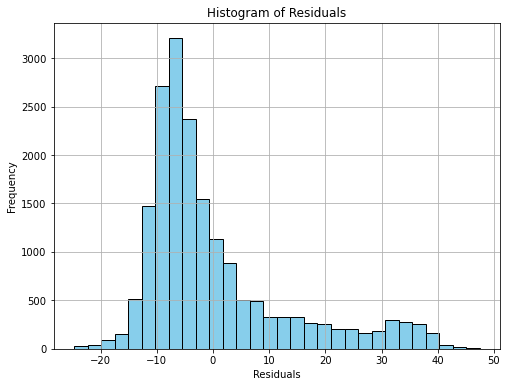

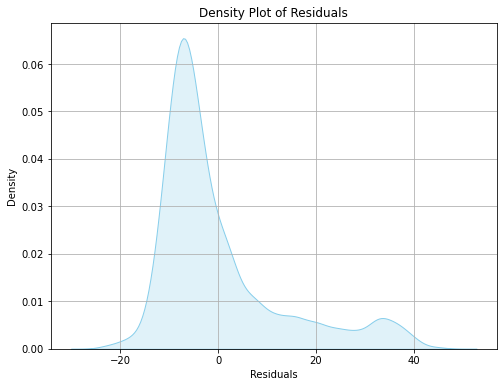

In [308]:
# Get the residuals from the fitted model
residuals = mos_num_results_final.resid

# Plot a histogram of the residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.grid(True)
plt.show()

# Plot a density plot of the residuals
plt.figure(figsize=(8, 6))
sns.kdeplot(residuals, color='skyblue', fill=True)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Density Plot of Residuals')
plt.grid(True)
plt.show()

***Observations***:

The distribution of the residuals looks somewhat like an extremely skewed normal distribution with a heavier right tail.

Let us use the Shapiro-Wilk test to confirm if this distribution is indeed normal. Recall that the Shapiro-Wilk test tests the null hypothesis that the data points are coming from a normal distribution. 

In [309]:
from scipy.stats import shapiro

# Getting the residuals from the fitted model:
residuals = mos_num_results_final.resid

# Running the Shapiro-Wilk test on the residuals:
statistic, p_value = shapiro(residuals)

# Printing the test statistic and p-value:
print("Shapiro-Wilk Test Statistic:", statistic)
print("p-value:", p_value)

Shapiro-Wilk Test Statistic: 0.8275230526924133
p-value: 0.0


C:\Users\simon\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Since the $p$-value = 0, we can reject the null hypothesis and conclude that residuals do not follow a normal distribution.

Let us now create a Q-Q Plot and see if it gives us any new information on the residuals. 

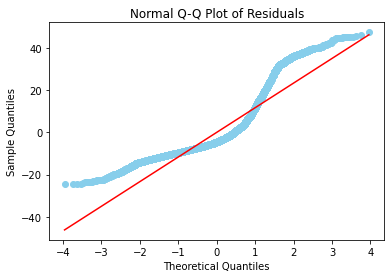

In [310]:
# Getting the residuals from the fitted model:
residuals = mos_num_results_final.resid

# Creating a normal Q-Q plot:
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Normal Q-Q Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

# Customizing the line colour:
plt.gca().get_lines()[0].set_color('skyblue')

plt.show()

***Observations***:

As expected, the Q-Q Plot indicates that the residuals are not from a normal distribution since there are too many deviations (and large ones) from the diagonal line, which represents where the residuals should be plotted if they came from a normal distribution. 

##### Linear Regression Assumption 4: Homoscedasticity

For this assumption, we need to check that our residuals have constant variance across all ranges of predicted values. To do this, we can plot our residuals against the values predicted by our model (fitted values).

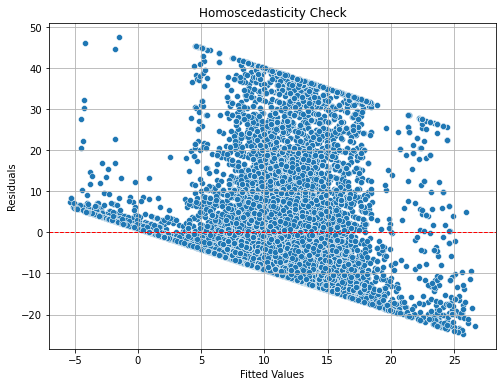

In [311]:
# Get the fitted values and residuals from the fitted model
model_fittedvals = mos_num_results_final.fittedvalues
model_resids = mos_num_results_final.resid

# Checking for homoscedasticity
plt.figure(figsize=(8, 6))
sns.scatterplot(x=model_fittedvals, y=model_resids)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)  # Add horizontal line at y=0
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Homoscedasticity Check')
plt.grid(True)
plt.show()

***Observations***: 
    
The above graph indicates that the variances of the residuals are not constant through all the ranges of the predicated values. Therefore, our model is not homoscedastic.   

***Summary***:

Although we were able to fit a linear regression model that was able to explain 9.1% of the variation in mosquito numbers, all four of the linear regression model assumptions failed: our model's independent variables do not have linear relationships with the dependent variable, our independent variables are not perfectly uncorrelated (or independent from each other), the residuals do not follow a normal distribution and the residuals do not exhibit constant variance (homoscedasticity). 

#### Question 3.2: <span style="font-size:14px; font-weight:normal;"> ***Running and analyzing a logistic regression model against the occurrence of WNV*** </span> 

This question asks us to run a logistic regression model to determine how the independent variables affect WNV presence. In this case, *wnv_present* will be our dependent variable. 

Let us now define our independent variables and run a recap of the correlation matrix.

*Note*: we are bringing back all of our independent variables, with the inclusion of *mosquito_number*, from the beginning of *Question 3.1* (those that were in our first iteration of our linear regression model).  

In [312]:
# Define matrix of independent variables:
W = df[['year', 'month', 'week', 'mosquito_number', 'trap_cdc', 'trap_gravid', 'trap_ovi', 'trap_sentinel', 'culex_pipiens', 'culex_restuans', 'culex_salinarius', 'culex_territans', 'lat', 'lon']]

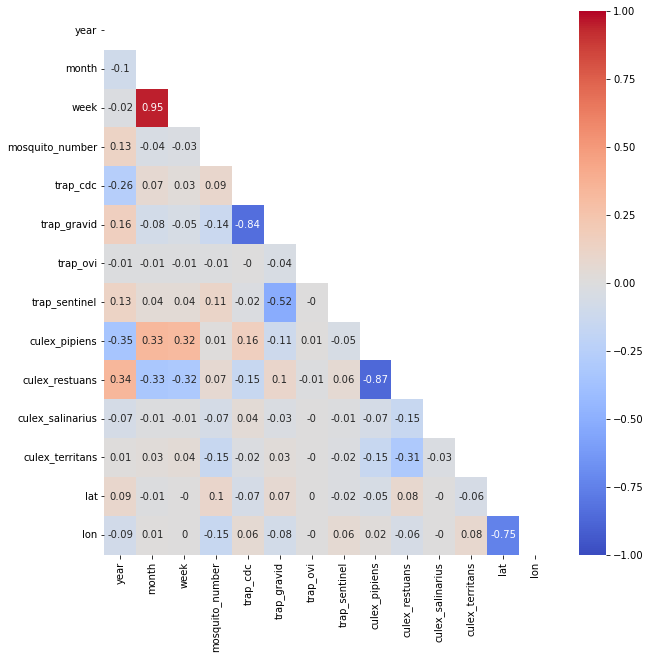

In [313]:
# Calculating the correlation matrix:
corr = W.corr()

# Creating the heatmap:
plt.figure(figsize=(10, 10))
sns.heatmap(corr.round(2), annot=True, vmax=1, vmin=-1, center=0, cmap="coolwarm", mask=np.triu(corr))
plt.show()

We see that the sample correlation coefficients are the same as in the last question and that the *mosquito_number* variable is not highly correlated to any of the other independent variables.

We will use the same iterative process as we did with the last question: we will drop independent variables from our model as we run it. However, these model summaries will not provide us with an $R^{2}$ value. Rather, we will be looking at whether the maximum likelihood optimization was a success and that the coefficients are significant. After we are satisfied, we will fit our logistic model and then run it for accuracy measurements. 

Let us start with the first iteration, which includes all independent variables and our dependent variable *wnv_present*. 

In [314]:
# Define independent variables:
W = df[['year', 'month', 'week', 'mosquito_number', 'trap_cdc', 'trap_gravid', 'trap_ovi', 'trap_sentinel', 'culex_pipiens', 'culex_restuans', 'culex_salinarius', 'culex_territans', 'lat', 'lon']]

# Define dependent variable
v = df['wnv_present']

# Adding a constant term to the independent variable
W_with_const = sm.add_constant(W)

# Fit the logistic regression model
logit_model = sm.Logit(v, W_with_const)
logit_result = logit_model.fit()

# Print summary of the logistic regression model
print(logit_result.summary())

         Current function value: 0.405443
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:            wnv_present   No. Observations:                18495
Model:                          Logit   Df Residuals:                    18482
Method:                           MLE   Df Model:                           12
Date:                Sun, 03 Mar 2024   Pseudo R-squ.:                  0.2229
Time:                        19:46:00   Log-Likelihood:                -7498.7
converged:                      False   LL-Null:                       -9649.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -348.0177        nan        nan        nan         nan         nan
year                 0.1130      0.007     16.4

C:\Users\simon\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


***Observations***

As expected, this analysis was not successful. Notice all the null values in place of the coefficients for our independent variables. The reason for this is due to the high collinearity between the independent variables.

We will begin by dropping the *month* variable and running the model. We will continue to drop the same variables as the last question and run the model at every instance until we get a successful optimization.

In [315]:
# Defining W without 'month':
W_1 = df[['year', 'week', 'mosquito_number', 'trap_cdc', 'trap_gravid', 'trap_ovi', 'trap_sentinel', 'culex_pipiens', 'culex_restuans', 'culex_salinarius', 'culex_territans', 'lat', 'lon']]
v = df['wnv_present']

# Adding a constant term to the independent variable:
W_with_const_1 = sm.add_constant(W_1)

# Fitting the logistic regression model:
logit_model_1 = sm.Logit(v, W_with_const_1)
logit_result_1 = logit_model_1.fit()

# Printing summary of the logistic regression model:
print(logit_result_1.summary())

         Current function value: 0.405718
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:            wnv_present   No. Observations:                18495
Model:                          Logit   Df Residuals:                    18483
Method:                           MLE   Df Model:                           11
Date:                Sun, 03 Mar 2024   Pseudo R-squ.:                  0.2224
Time:                        19:46:00   Log-Likelihood:                -7503.8
converged:                      False   LL-Null:                       -9649.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -342.7148        nan        nan        nan         nan         nan
year                 0.1092      0.007     16.1

C:\Users\simon\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [316]:
# Defining W without 'trap_cdc':
W_2 = df[['year', 'week', 'mosquito_number', 'trap_gravid', 'trap_ovi', 'trap_sentinel', 'culex_pipiens', 'culex_restuans', 'culex_salinarius', 'culex_territans', 'lat', 'lon']]
v = df['wnv_present']

# Adding a constant term to the independent variable:
W_with_const_2 = sm.add_constant(W_2)

# Fitting the logistic regression model:
logit_model_2 = sm.Logit(v, W_with_const_2)
logit_result_2 = logit_model_2.fit()

# Printing summary of the logistic regression model:
print(logit_result_2.summary())

         Current function value: 0.405718
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:            wnv_present   No. Observations:                18495
Model:                          Logit   Df Residuals:                    18483
Method:                           MLE   Df Model:                           11
Date:                Sun, 03 Mar 2024   Pseudo R-squ.:                  0.2224
Time:                        19:46:00   Log-Likelihood:                -7503.8
converged:                      False   LL-Null:                       -9649.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -409.0298        nan        nan        nan         nan         nan
year                 0.1092      0.007     16.1

C:\Users\simon\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [317]:
# Defining W without 'culex_pipiens':
W_3 = df[['year', 'week', 'mosquito_number', 'trap_gravid', 'trap_ovi', 'trap_sentinel', 'culex_restuans', 'culex_salinarius', 'culex_territans', 'lat', 'lon']]
v = df['wnv_present']

# Adding a constant term to the independent variable:
W_with_const_3 = sm.add_constant(W_3)

# Fitting the logistic regression model:
logit_model_3 = sm.Logit(v, W_with_const_3)
logit_result_3 = logit_model_3.fit()

# Printing summary of the logistic regression model:
print(logit_result_3.summary())

         Current function value: 0.405718
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:            wnv_present   No. Observations:                18495
Model:                          Logit   Df Residuals:                    18483
Method:                           MLE   Df Model:                           11
Date:                Sun, 03 Mar 2024   Pseudo R-squ.:                  0.2224
Time:                        19:46:01   Log-Likelihood:                -7503.8
converged:                      False   LL-Null:                       -9649.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -510.3521     25.065    -20.362      0.000    -559.478    -461.226
year                 0.1092      0.007     16.1

C:\Users\simon\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [318]:
# Defining W without 'lat':
W_4 = df[['year', 'week', 'mosquito_number', 'trap_gravid', 'trap_ovi', 'trap_sentinel', 'culex_restuans', 'culex_salinarius', 'culex_territans', 'lon']]
v = df['wnv_present']

# Adding a constant term to the independent variable:
W_with_const_4 = sm.add_constant(W_4)

# Fitting the logistic regression model:
logit_model_4 = sm.Logit(v, W_with_const_4)
logit_result_4 = logit_model_4.fit()

# Printing summary of the logistic regression model:
print(logit_result_4.summary())

         Current function value: 0.405861
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:            wnv_present   No. Observations:                18495
Model:                          Logit   Df Residuals:                    18484
Method:                           MLE   Df Model:                           10
Date:                Sun, 03 Mar 2024   Pseudo R-squ.:                  0.2221
Time:                        19:46:01   Log-Likelihood:                -7506.4
converged:                      False   LL-Null:                       -9649.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -486.1037     22.708    -21.407      0.000    -530.610    -441.598
year                 0.1092      0.007     16.1

C:\Users\simon\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [319]:
# Defining W without 'trap_sentinel':
W_5 = df[['year', 'week', 'mosquito_number', 'trap_gravid', 'trap_ovi', 'culex_restuans', 'culex_salinarius', 'culex_territans', 'lon']]
v = df['wnv_present']

# Adding a constant term to the independent variable:
W_with_const_5 = sm.add_constant(W_5)

# Fitting the logistic regression model:
logit_model_5 = sm.Logit(v, W_with_const_5)
logit_result_5 = logit_model_5.fit()

# Printing summary of the logistic regression model:
print(logit_result_5.summary())

         Current function value: 0.405910
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:            wnv_present   No. Observations:                18495
Model:                          Logit   Df Residuals:                    18485
Method:                           MLE   Df Model:                            9
Date:                Sun, 03 Mar 2024   Pseudo R-squ.:                  0.2220
Time:                        19:46:01   Log-Likelihood:                -7507.3
converged:                      False   LL-Null:                       -9649.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -482.2018     22.507    -21.424      0.000    -526.315    -438.088
year                 0.1070      0.007     16.3

C:\Users\simon\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [320]:
# Defining W without 'trap_ovi':
W_6 = df[['year', 'week', 'mosquito_number', 'trap_gravid', 'culex_restuans', 'culex_salinarius', 'culex_territans', 'lon']]
v = df['wnv_present']

# Adding a constant term to the independent variable:
W_with_const_6 = sm.add_constant(W_6)

# Fitting the logistic regression model:
logit_model_6 = sm.Logit(v, W_with_const_6)
logit_result_6 = logit_model_6.fit()

# Printing summary of the logistic regression model:
print(logit_result_6.summary())

Optimization terminated successfully.
         Current function value: 0.405911
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            wnv_present   No. Observations:                18495
Model:                          Logit   Df Residuals:                    18486
Method:                           MLE   Df Model:                            8
Date:                Sun, 03 Mar 2024   Pseudo R-squ.:                  0.2220
Time:                        19:46:01   Log-Likelihood:                -7507.3
converged:                       True   LL-Null:                       -9649.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -482.1972     22.507    -21.424      0.000    -526.311    -438.083
year       

***Observations***:

Our model has finally terminated successfully. Our coefficients are significant ($p$-value <0.05) and we can continue our iterative process by checking our model for accuracy. 

Recall that our linear regression model gives us the *estimated expected value* for our dependent variable whereas our logistic model gives us the *probability* that our dependent variable will occur. 

To determine the accuracy for our model, we set the model probability prediction level at the standard 0.5.


In [321]:
# Getting probabilistic predictions:
model_predictions_prob_6 = logit_result_6.predict(W_with_const_6)

# Converting probabilistic predictions to binary predictions:
model_predictions_binary_6 = (model_predictions_prob_6 >= 0.5).astype(int)

# Calculating rounded mean accuracy:
accuracy = np.mean(model_predictions_binary_6 == v)
rounded_accuracy = round(accuracy, 4)
print("Mean Accuracy:", rounded_accuracy)

Mean Accuracy: 0.8108


***Observations***:

The mean accuracy of 0.8108 tells us that our model predicted 81% of our data points correctly.

Let us see if we can increase this accuracy by dropping some variables. Again, we will use an iterative process, and our evaluation standard will be the mean accuracy of the model.  


In [322]:
# Defining W without 'culex_salinarius':
W_7 = df[['year', 'week', 'mosquito_number', 'trap_gravid', 'culex_restuans', 'culex_territans', 'lon']]
v = df['wnv_present']

# Adding a constant term to the independent variable:
W_with_const_7 = sm.add_constant(W_7)

# Fitting the logistic regression model:
logit_model_7 = sm.Logit(v, W_with_const_7)
logit_result_7 = logit_model_7.fit()

# Getting probabilistic predictions:
model_predictions_prob_7 = logit_result_7.predict(W_with_const_7)

# Converting probabilistic predictions to binary predictions:
model_predictions_binary_7 = (model_predictions_prob_7 >= 0.5).astype(int)

# Calculating rounded mean accuracy:
accuracy = np.mean(model_predictions_binary_7 == v)
rounded_accuracy = round(accuracy, 4)
print("Mean Accuracy:", rounded_accuracy)

Optimization terminated successfully.
         Current function value: 0.406253
         Iterations 8
Mean Accuracy: 0.8103


In [323]:
# Defining W without 'culex_territans':
W_8 = df[['year', 'week', 'mosquito_number', 'trap_gravid', 'culex_restuans',  'lon']]
v = df['wnv_present']

# Adding a constant term to the independent variable:
W_with_const_8 = sm.add_constant(W_8)

# Fitting the logistic regression model:
logit_model_8 = sm.Logit(v, W_with_const_8)
logit_result_8 = logit_model_8.fit()

# Getting probabilistic predictions:
model_predictions_prob_8 = logit_result_8.predict(W_with_const_8)

# Converting probabilistic predictions to binary predictions:
model_predictions_binary_8 = (model_predictions_prob_8 >= 0.5).astype(int)

# Calculating rounded mean accuracy:
accuracy = np.mean(model_predictions_binary_8 == v)
rounded_accuracy = round(accuracy, 4)
print("Mean Accuracy:", rounded_accuracy)

Optimization terminated successfully.
         Current function value: 0.411064
         Iterations 8
Mean Accuracy: 0.8105


In [324]:
# Defining W without 'year':
W_9 = df[['week', 'mosquito_number', 'trap_gravid', 'culex_restuans',  'lon']]
v = df['wnv_present']

# Adding a constant term to the independent variable:
W_with_const_9 = sm.add_constant(W_9)

# Fitting the logistic regression model:
logit_model_9 = sm.Logit(v, W_with_const_9)
logit_result_9 = logit_model_9.fit()

# Getting probabilistic predictions:
model_predictions_prob_9 = logit_result_9.predict(W_with_const_9)

# Converting probabilistic predictions to binary predictions:
model_predictions_binary_9 = (model_predictions_prob_9 >= 0.5).astype(int)

# Calculating rounded mean accuracy:
accuracy = np.mean(model_predictions_binary == v)
rounded_accuracy = round(accuracy, 4)
print("Mean Accuracy:", rounded_accuracy)

Optimization terminated successfully.
         Current function value: 0.417421
         Iterations 7
Mean Accuracy: 0.8075


In [325]:
# Defining W without 'culex_restuans', but with 'year' added:
W_10 = df[['year', 'week', 'mosquito_number', 'trap_gravid', 'lon']]
v = df['wnv_present']

# Adding a constant term to the independent variable:
W_with_const_10 = sm.add_constant(W_10)

# Fitting the logistic regression model:
logit_model_10 = sm.Logit(v, W_with_const_10)
logit_result_10 = logit_model_10.fit()

# Getting probabilistic predictions:
model_predictions_prob_10 = logit_result_10.predict(W_with_const_10)

# Converting probabilistic predictions to binary predictions:
model_predictions_binary_10 = (model_predictions_prob_10 >= 0.5).astype(int)

# Calculating rounded mean accuracy:
accuracy = np.mean(model_predictions_binary_10 == v)
rounded_accuracy = round(accuracy, 4)
print("Mean Accuracy:", rounded_accuracy)

Optimization terminated successfully.
         Current function value: 0.411129
         Iterations 8
Mean Accuracy: 0.811


In [326]:
# Defining W without 'trap_gravid':
W_11 = df[['year', 'week', 'mosquito_number', 'lon']]
v = df['wnv_present']

# Adding a constant term to the independent variable:
W_with_const_11 = sm.add_constant(W_11)

# Fitting the logistic regression model:
logit_model_11 = sm.Logit(v, W_with_const_11)
logit_result_11 = logit_model_11.fit()

# Getting probabilistic predictions:
model_predictions_prob_11 = logit_result_11.predict(W_with_const_11)

# Converting probabilistic predictions to binary predictions:
model_predictions_binary_11 = (model_predictions_prob_11 >= 0.5).astype(int)

# Calculating rounded mean accuracy:
accuracy = np.mean(model_predictions_binary_11 == v)
rounded_accuracy = round(accuracy, 4)
print("Mean Accuracy:", rounded_accuracy)

Optimization terminated successfully.
         Current function value: 0.411232
         Iterations 8
Mean Accuracy: 0.8107


It seems that the 10th iteration's mean accurancy is at 0.811 versus our 6th iteration's mean accuracy of 0.8108. However, if we print the summary for our 10th iteration logistic model (see below), we will see that *trap_gravid* is not a significant predictor. In which case, our 11th iteration above, that does not include *trap_gravid*, has a mean accuracy of 0.8107, which is a little smaller than our 6th iteration's mean accuracy. 

In [327]:
# Defining W without 'culex_restuans', but with 'year' added:
W_10 = df[['year', 'week', 'mosquito_number', 'trap_gravid', 'lon']]
v = df['wnv_present']

# Adding a constant term to the independent variable:
W_with_const_10 = sm.add_constant(W_10)

# Fitting the logistic regression model:
logit_model_10 = sm.Logit(v, W_with_const_10)
logit_result_10 = logit_model_10.fit()

# Printing summary of the logistic regression model:
print(logit_result_10.summary())

Optimization terminated successfully.
         Current function value: 0.411129
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            wnv_present   No. Observations:                18495
Model:                          Logit   Df Residuals:                    18489
Method:                           MLE   Df Model:                            5
Date:                Sun, 03 Mar 2024   Pseudo R-squ.:                  0.2120
Time:                        19:46:04   Log-Likelihood:                -7603.8
converged:                       True   LL-Null:                       -9649.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -459.7126     21.585    -21.297      0.000    -502.019    -417.406
year          

***Fitting the model***

This where our analysis gets a little controversial. As stated earlier, it is our belief that, all things being equal, a model with less independent variables is better. So far, the 6th iteration of our logistic models gives us the highest mean accuracy with all predictor variables being significant. 

However, if we round our mean accuracy to 2, all of the mean accuracies will be at 0.81 (81%). If we are looking for a model with minimal variables and a mean accuracy of 81%, consider the following iteration, along with the correlation matrix:

In [328]:
W_min = df[['week', 'mosquito_number', 'lon']]

# Define dependent variable
v = df['wnv_present']

# Adding a constant term to the independent variable
W_with_const_min = sm.add_constant(W_min)

# Fit the logistic regression model
logit_model_min = sm.Logit(v, W_with_const_min)
logit_result_min = logit_model_min.fit()

# Print summary of the logistic regression model
print(logit_result_min.summary())

Optimization terminated successfully.
         Current function value: 0.418660
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            wnv_present   No. Observations:                18495
Model:                          Logit   Df Residuals:                    18491
Method:                           MLE   Df Model:                            3
Date:                Sun, 03 Mar 2024   Pseudo R-squ.:                  0.1976
Time:                        19:46:05   Log-Likelihood:                -7743.1
converged:                       True   LL-Null:                       -9649.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -306.4327     18.331    -16.717      0.000    -342.361    -270.505
week          

In [329]:
# Getting probabilistic predictions
model_predictions_prob_min = logit_result_min.predict(W_with_const_min)

# Converting probabilistic predictions to binary predictions
model_predictions_binary = (model_predictions_prob_min >= 0.5).astype(int)

# Calculating mean accuracy
accuracy = np.mean(model_predictions_binary == v)
rounded_accuracy = round(accuracy, 2)
print("Mean Accuracy:", rounded_accuracy)

Mean Accuracy: 0.81


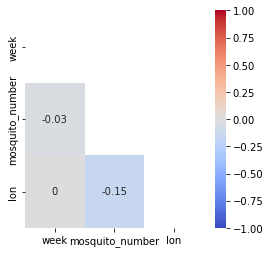

In [330]:
# Calculating the correlation matrix:
corr = W_min.corr()

# Creating the heatmap:
plt.figure(figsize=(4, 4))
sns.heatmap(corr.round(2), annot=True, vmax=1, vmin=-1, center=0, cmap="coolwarm", mask=np.triu(corr))
plt.show()

***Observations***: For the model with independent variables *week*, *mosquito_number* and *lon*, all of our independent variables are significant, they are close to being almost perfectly uncorrelated, and the mean accuracy for the logisitic model is 81%.

For the 6th iteration's correlation matrix, where the independent variable are *year*, *week*, *mosquito_number*, *trap_gravid*, *culex_restuans*, *culex_salinarius*, *culex_territans* and *lon*, we get:

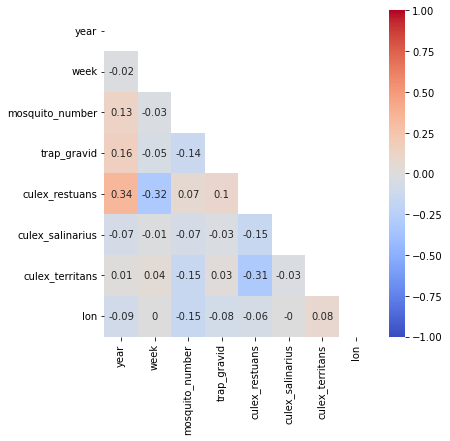

In [339]:
# Calculating the correlation matrix:
corr = W_6.corr()

# Creating the heatmap:
plt.figure(figsize=(6, 6))
sns.heatmap(corr.round(2), annot=True, vmax=1, vmin=-1, center=0, cmap="coolwarm", mask=np.triu(corr))
plt.show()

Since this deliverable is also an exercise in experimentation, let us fit both models (W_min and W_6) and then evaluate the models using residual analysis. We will start with the smaller model first. 

***Fitting and performing residual analysis on model 1***

In [333]:
# Extracting coefficients:
coef = logit_result_min.params.round(4)

# Printing coefficients:
print("Coefficients:")
print(coef)

Coefficients:
const             -306.4327
week                 0.1487
mosquito_number      0.0679
lon                 -3.4143
dtype: float64


Since $ f(\overrightarrow{x}) =   -306.4327 + 0.1487x_{1} +  0.0679x_{2} - 3.4143x_{3}$
our model becomes:

$ \sigma(f(\overrightarrow{x})) = \displaystyle{\frac{1}{1+e^{-f(\overrightarrow{x})}}} = \displaystyle{\frac{1}{1+e^{( -306.4327 + 0.1487x_{1} +  0.0679x_{2} - 3.4143x_{3})}}}$

where,

$ X_{1} \sim $ *week*

$ X_{2} \sim $ *mosquito_number*

$ X_{3} \sim $ *lon*.

Let us now evaluate the model using residual analysis. While logistic regression doesn't have residuals in the same way as linear regression, we can still examine residuals by plotting predicted probabilities against observed outcomes or using deviance residuals to assess model fit.

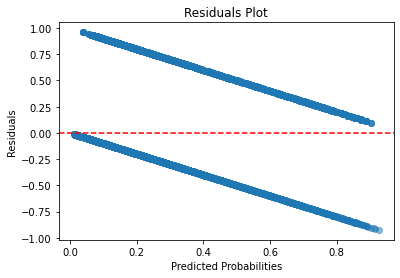

In [334]:
# Getting the predicted probabilities from the model:
predicted_probs = logit_result_min.predict(W_with_const_min)

# Calculating the residuals:
residuals = v - predicted_probs

# Creating a residuals plot:
plt.scatter(predicted_probs, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Probabilities')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

***Observations***:

The two linear lines indicate that the residuals are not randomly distributed around the horizontal line at 0. This pattern in the residuals could imply that the model is missing some important information or that the underlying relationship between the predictors and the dependent variable is not well captured by the model. Moreover, the lines suggest that there could be a bias in the residuals and that the variance is not constant (heteroscedasticity). 

***Fitting and performing residual analysis on model 2***

In [335]:
# Extracting coefficients:
coef = logit_result_6.params.round(4)

# Printing coefficients:
print("Coefficients:")
print(coef)

Coefficients:
const              -482.1972
year                  0.1070
week                  0.1476
mosquito_number       0.0651
trap_gravid           0.2230
culex_restuans       -0.2587
culex_salinarius     -1.0023
culex_territans      -2.4946
lon                  -2.9638
dtype: float64


Since $ f(\overrightarrow{x}) =   -482.1972 + 0.1070x_{1} +  0.1476x_{2} - 0.0651x_{3} + 0.2230x_{4} - 0.2587x_{5} - 1.0023x_{6} -2.4946x_{7} - 2.9638x_{8} $,

our model becomes:

$ \sigma(f(\overrightarrow{x})) = \displaystyle{\frac{1}{1+e^{-f(\overrightarrow{x})}}} = \displaystyle{\frac{1}{1+e^{(-482.1972 + 0.1070x_{1} +  0.1476x_{2} - 0.0651x_{3} + 0.2230x_{4} - 0.2587x_{5} - 1.0023x_{6} -2.4946x_{7} - 2.9638x_{8})}}} $,

where,

$ X_{1} \sim $ *year*

$ X_{2} \sim $ *week*

$ X_{3} \sim $ *mosquito_number*

$ X_{4} \sim $ *trap_gravid*

$ X_{5} \sim $ *culex_restuans*

$ X_{6} \sim $ *culex_salinarius*

$ X_{7} \sim $ *culex_territans*

$X_{8} \sim $ *lon*.

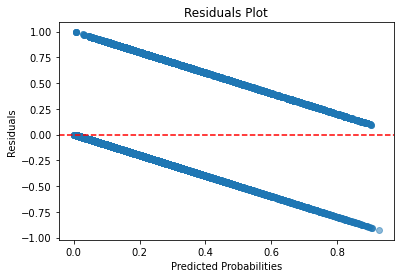

In [336]:
# Getting the predicted probabilities from the model:
predicted_probs_6 = logit_result_6.predict(W_with_const_6)

# Calculating the residuals:
residuals_6 = v - predicted_probs_6

# Creating a residuals plot:
plt.scatter(predicted_probs_6, residuals_6, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Probabilities')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

***Observations***:

The residual analysis for model 2 is almost identical to that of model 1: the analysis suggest that there could be a bias in the residuals and that there is heteroscedasticity. 

***Calibration curves***

Without going beyond the scope of this deliverable, we can do one more simple analysis on both our models: we can plot a calibration curve for both. This involves plotting the observed outcome frequency against the predicted probabilities to assess how well the model's predicted probabilities align with the actual outcome probabilities.We plot the calibration curve, along with the perfectly calibrated line (the diagonal line) and this line represents perfect calibration, where predicted probabilities match the actual fraction of positives. If the calibration curve deviates from the perfectly calibrated line, it indicates that the model's predicted probabilities are not well-calibrated. Let us run plots for both models, starting with the smaller model first.

*Note*: for this, we have to import *calibration_curve* from *sklearn.calibration*. 

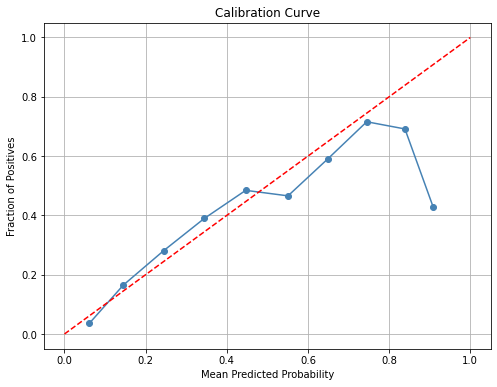

In [337]:
from sklearn.calibration import calibration_curve

# Get the predicted probabilities from the logistic regression model
predicted_probs = logit_result_min.predict(W_with_const_min)

# Calculate the calibration curve
prob_true, prob_pred = calibration_curve(v, predicted_probs, n_bins=10, strategy='uniform')

# Plot the calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', color='steelblue')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')  # Perfectly calibrated line
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.grid(True)
plt.show()

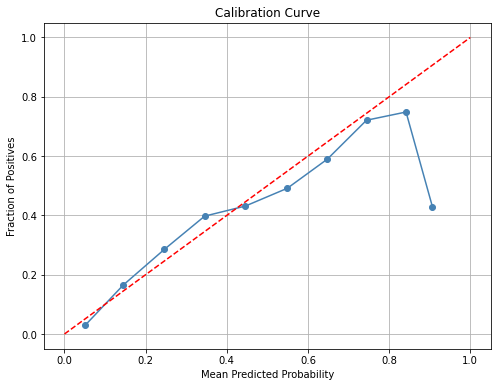

In [338]:
# Get the predicted probabilities from the logistic regression model
predicted_probs_6 = logit_result_6.predict(W_with_const_6)

# Calculate the calibration curve
prob_true, prob_pred = calibration_curve(v, predicted_probs_6, n_bins=10, strategy='uniform')

# Plot the calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', color='steelblue')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')  # Perfectly calibrated line
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.grid(True)
plt.show()

***Observations***

Both models have almost identical calibration curves. For both models, there is some over and underestimation, which indicates bias. For both models, the curve drastically drops and deviates from the perfectly calibrated line after the mean predicted probability of 0.81. 

***Summary***

Since both models have mean accuracy of 81%, have significant predictor variables, and have the same results when running a few evalution tests, it is our opinion that the reader can chose which of the two models they prefer:

$ \sigma_{1}(f_{1}) =\displaystyle{\frac{1}{1+e^{( -306.4327 + 0.1487x_{2} +  0.0679x_{3} - 3.4143x_{8})}}}$, 

or

$ \sigma_{2}(f_{2}) = \displaystyle{\frac{1}{1+e^{(-482.1972 + 0.1070x_{1} +  0.1476x_{2} - 0.0651x_{3} + 0.2230x_{4} - 0.2587x_{5} - 1.0023x_{6} -2.4946x_{7} - 2.9638x_{8})}}} $,

where 

$f_{1}=  -306.4327 + 0.1487x_{2} +  0.0679x_{3} - 3.4143x_{8}$,

$f_{2}= -482.1972 + 0.1070x_{1} +  0.1476x_{2} - 0.0651x_{3} + 0.2230x_{4} - 0.2587x_{5} - 1.0023x_{6} -2.4946x_{7} - 2.9638x_{8} $,

and

$ X_{1} \sim $ *year*

$ X_{2} \sim $ *week*

$ X_{3} \sim $ *mosquito_number*

$ X_{4} \sim $ *trap_gravid*

$ X_{5} \sim $ *culex_restuans*

$ X_{6} \sim $ *culex_salinarius*

$ X_{7} \sim $ *culex_territans*

$X_{8} \sim $ *lon*.